In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

from joblib import dump, load

In [4]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/otras regiones/Modos/descomposicion_barranquillita/Modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/otras regiones/Modos/descomposicion_barranquillita/Modo_2.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/otras regiones/Modos/descomposicion_barranquillita/Residuo.csv")
modos = [modo_1,modo_2,residuo]

for i in modos:
  i["FECHA"] = pd.to_datetime(i["FECHA"],format='%Y-%m-%d')
  i.set_index("FECHA", inplace=True)

<Axes: xlabel='FECHA'>

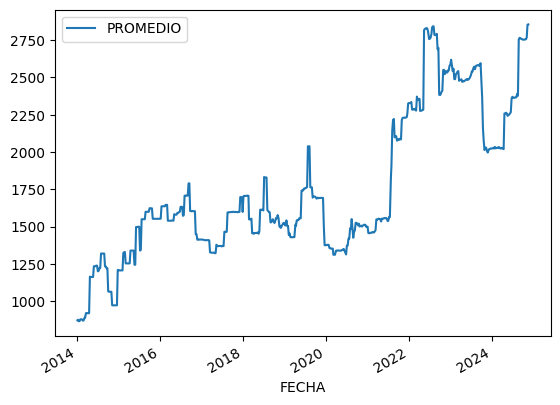

In [5]:
datos_emd = modo_1 + modo_2 + residuo
datos_emd.plot()

In [6]:
futuros = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Datos históricos Futuros maíz EE.UU..csv" )
futuros = futuros[["Fecha","Último"]]
futuros["Fecha"]=pd.to_datetime(futuros["Fecha"],dayfirst=True)
futuros.rename(columns={"Último":"Futuro"},inplace=True)
futuros["Futuro"] = futuros["Futuro"].str.replace(",",".").astype(float)
futuros.set_index("Fecha", inplace=True)
futuros.head()

,Futuro
Fecha,
2024-11-04,416.10
2024-11-01,414.50
2024-10-31,410.75
2024-10-30,411.50
2024-10-29,413.75


In [7]:
futuros_values = futuros.values
futuros_values = futuros_values.astype('float32')
futuros_scaler = MinMaxScaler(feature_range=(-1, 1))
futuros_escalada =  pd.DataFrame(futuros_scaler.fit_transform(futuros_values), columns=futuros.columns,index=futuros.index)

In [8]:
def add_lags(df,pasos):
    target_map = df['PROMEDIO'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = df['PROMEDIO'].shift(i)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [9]:
PASOS = 7
CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7", "Futuro"]

In [10]:
def to_sup(modo):
  modo_values = modo.values
  modo_values = modo_values.astype('float32')
  modo_scaler = MinMaxScaler(feature_range=(-1, 1))

  modo_escalado =  pd.DataFrame(modo_scaler.fit_transform(modo_values), columns=modo.columns,index=modo.index)
  modo_sup = add_lags(modo_escalado, PASOS)
  modo_sup = pd.merge( modo_sup,futuros_escalada,left_index=True, right_index=True, how='inner')
  modo_sup.head(5)
  return modo_scaler, modo_sup

# Primer Modo

In [11]:
modo_1_scaler, modo_1_sup = to_sup(modo_1)
modo_1_sup.head()

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7,Futuro
2014-02-19,-0.050393,-0.013114,0.008163,0.034823,0.002345,0.008625,0.041675,0.015884,-0.409028
2014-02-26,-0.025074,-0.050393,-0.013114,0.008163,0.034823,0.002345,0.008625,0.041675,-0.406236
2014-03-07,0.102013,-0.025074,-0.050393,-0.013114,0.008163,0.034823,0.002345,0.008625,-0.302001
2014-03-12,0.148496,0.102013,-0.025074,-0.050393,-0.013114,0.008163,0.034823,0.002345,-0.303862
2014-03-19,0.294553,0.148496,0.102013,-0.025074,-0.050393,-0.013114,0.008163,0.034823,-0.288041


In [12]:
total_datos=len(modo_1_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_testeo_m1 = modo_1_sup[division_entrenamiento:total_datos]

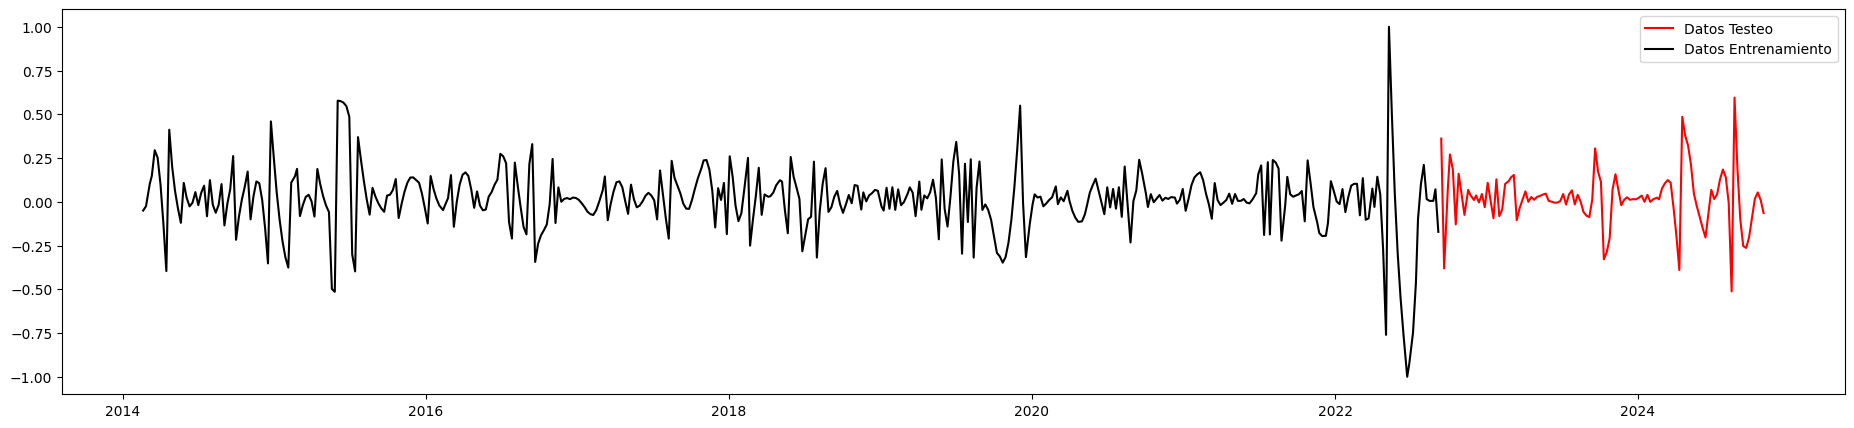

In [13]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [14]:
modelo_1 = load("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Futuros_maiz/Modelos/LGBM/LGBM_m1.joblib")

In [15]:
X_train = datos_entrenamiento_m1[CARACTERISTICAS]
y_train = datos_entrenamiento_m1["PROMEDIO"]

X_test = datos_testeo_m1[CARACTERISTICAS]
y_test = datos_testeo_m1["PROMEDIO"]

modelo_1.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)])

prediccion_modo_1 = modelo_1.predict(X_test)
recm = np.sqrt(mean_squared_error(prediccion_modo_1,y_test))
ecm = mean_squared_error(prediccion_modo_1,y_test)
mae = mean_absolute_error(prediccion_modo_1,y_test)
mape = mean_absolute_percentage_error(prediccion_modo_1,y_test)

print(f"El error cuadratico medio del modelo es {ecm}")
print(f"La raiz error cuadratico medio del modelo es {recm}")
print(f"El error absoluto medio del modelo es {mae}")
print(f"porcentaje de error absoluto medio del modelo es ")

El error cuadratico medio del modelo es 0.025072951739257644
La raiz error cuadratico medio del modelo es 0.15834440861381133
El error absoluto medio del modelo es 0.10663114743979589
porcentaje de error absoluto medio del modelo es 


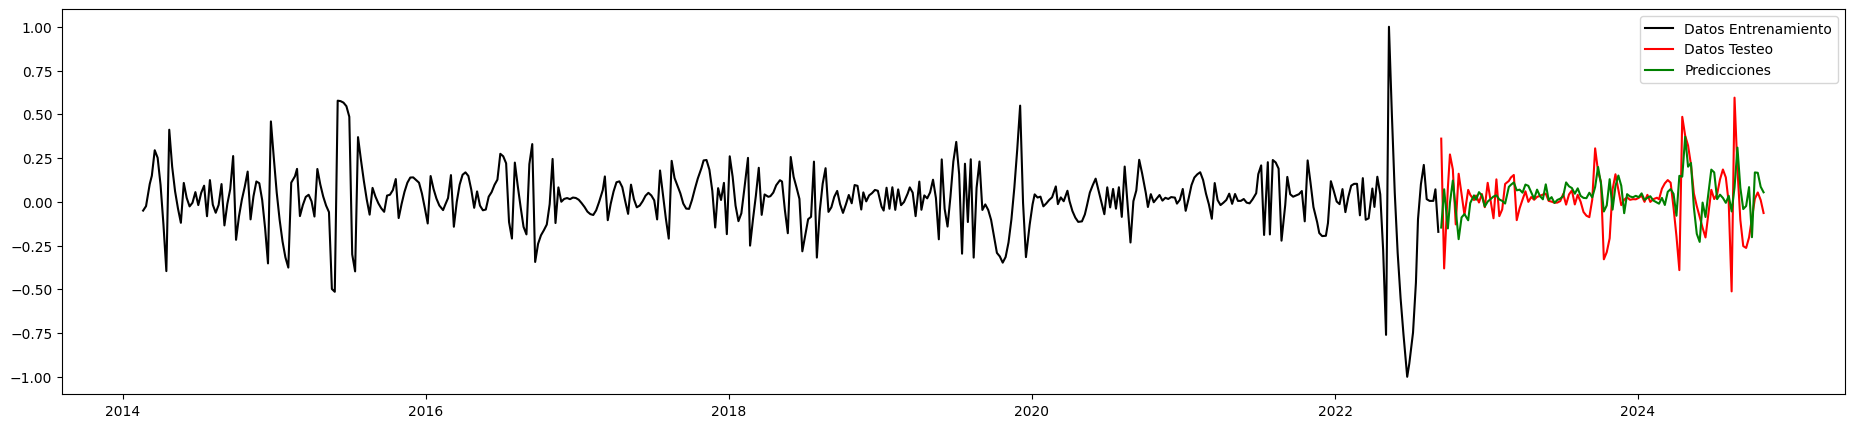

In [16]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m1.index,prediccion_modo_1,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [17]:
prediccion_modo_1 = modo_1_scaler.inverse_transform(prediccion_modo_1.reshape(-1, 1))

# Modo 2

In [18]:
modo_2_scaler, modo_2_sup = to_sup(modo_2)
modo_2_sup.head()

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7,Futuro
2014-02-19,0.243265,0.246065,0.205570,0.143592,0.080824,0.030363,-0.004978,-0.030259,-0.409028
2014-02-26,0.182734,0.243265,0.246065,0.205570,0.143592,0.080824,0.030363,-0.004978,-0.406236
2014-03-07,0.074918,0.182734,0.243265,0.246065,0.205570,0.143592,0.080824,0.030363,-0.302001
2014-03-12,-0.058404,0.074918,0.182734,0.243265,0.246065,0.205570,0.143592,0.080824,-0.303862
2014-03-19,-0.174693,-0.058404,0.074918,0.182734,0.243265,0.246065,0.205570,0.143592,-0.288041


In [19]:
total_datos=len(modo_2_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_testeo_m2 = modo_2_sup[division_entrenamiento:total_datos]

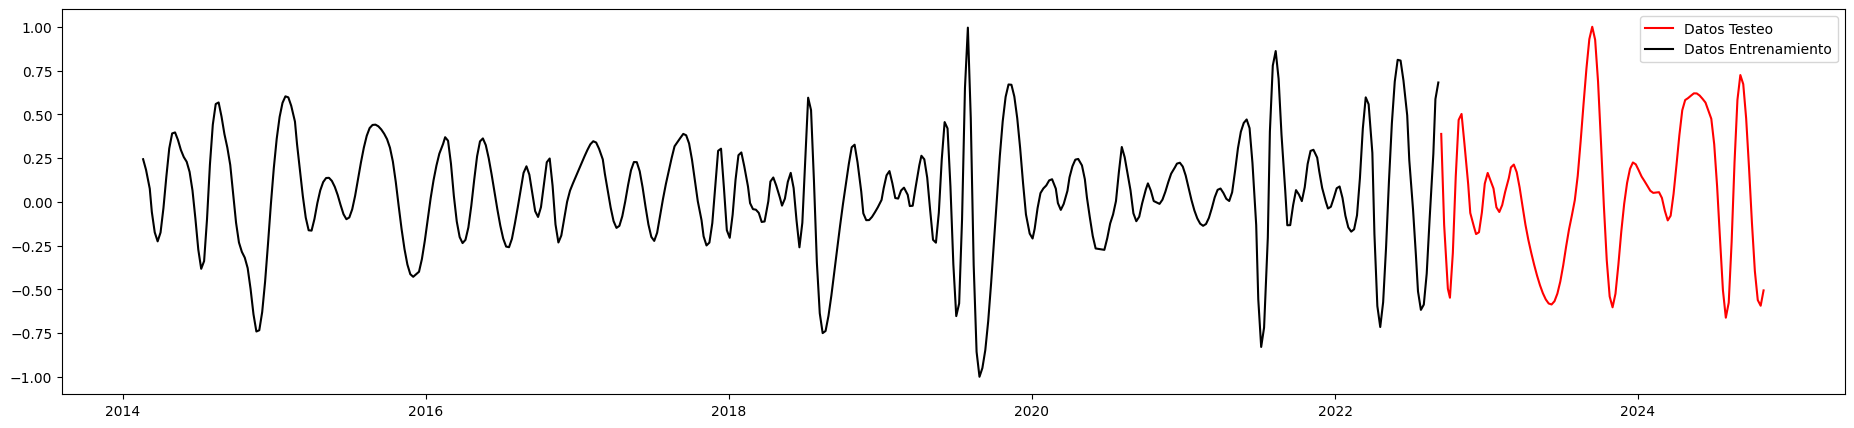

In [20]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [21]:
modelo_2 = load("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Futuros_maiz/Modelos/LGBM/LGBM_m2.joblib")

In [22]:
X_train = datos_entrenamiento_m2[CARACTERISTICAS]
y_train = datos_entrenamiento_m2["PROMEDIO"]

X_test = datos_testeo_m2[CARACTERISTICAS]
y_test = datos_testeo_m2["PROMEDIO"]

modelo_2.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)])

prediccion_modo_2 = modelo_2.predict(X_test)
recm = np.sqrt(mean_squared_error(prediccion_modo_2,y_test))
ecm = mean_squared_error(prediccion_modo_2,y_test)
mae = mean_absolute_error(prediccion_modo_2,y_test)
mape = mean_absolute_percentage_error(prediccion_modo_2,y_test)

print(f"El error cuadratico medio del modelo es {ecm}")
print(f"La raiz error cuadratico medio del modelo es {recm}")
print(f"El error absoluto medio del modelo es {mae}")
print(f"porcentaje de error absoluto medio del modelo")

El error cuadratico medio del modelo es 0.014502523769353976
La raiz error cuadratico medio del modelo es 0.12042642471382257
El error absoluto medio del modelo es 0.08846421197324399
porcentaje de error absoluto medio del modelo


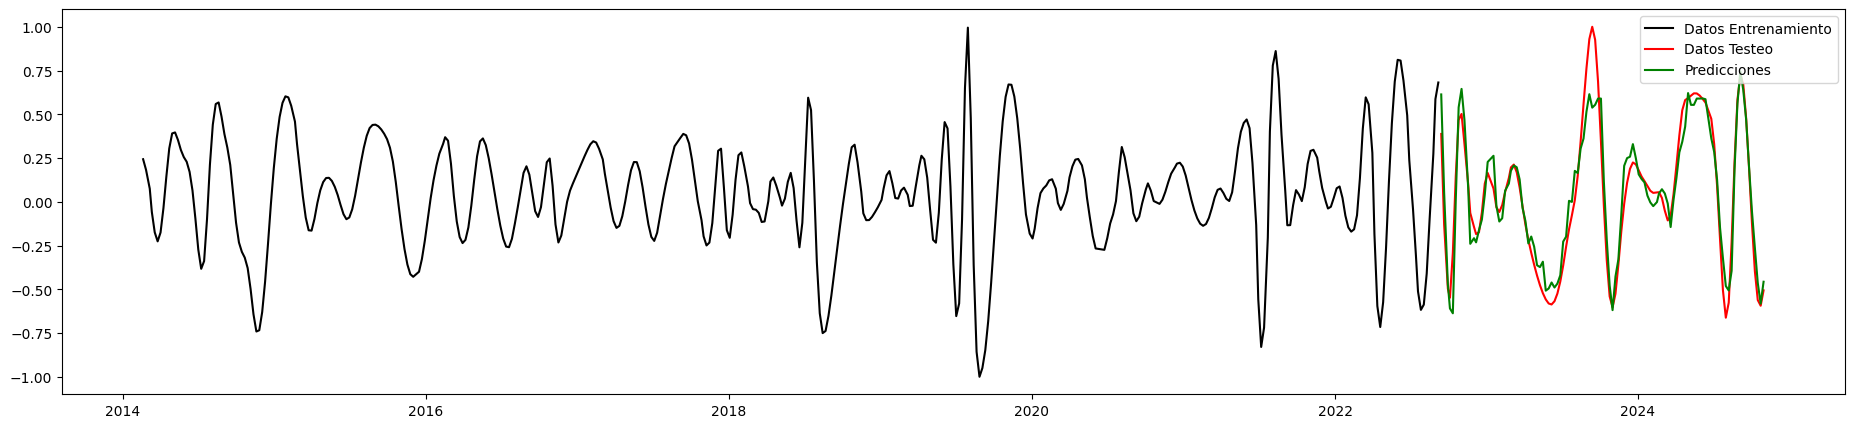

In [23]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m2.index,prediccion_modo_2,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [24]:

prediccion_modo_2 = modo_2_scaler.inverse_transform(prediccion_modo_2.reshape(-1, 1))

# Residuo

In [25]:
residuo_scaler, residuo_sup = to_sup(residuo)
residuo_sup.head()

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7,Futuro
2014-02-19,-0.998995,-1.000000,-0.997882,-0.993356,-0.987190,-0.980151,-0.972938,-0.965958,-0.409028
2014-02-26,-0.994418,-0.998995,-1.000000,-0.997882,-0.993356,-0.987190,-0.980151,-0.972938,-0.406236
2014-03-07,-0.986123,-0.994418,-0.998995,-1.000000,-0.997882,-0.993356,-0.987190,-0.980151,-0.302001
2014-03-12,-0.974025,-0.986123,-0.994418,-0.998995,-1.000000,-0.997882,-0.993356,-0.987190,-0.303862
2014-03-19,-0.958039,-0.974025,-0.986123,-0.994418,-0.998995,-1.000000,-0.997882,-0.993356,-0.288041


In [26]:
total_datos=len(residuo_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_testeo_residuo = residuo_sup[division_entrenamiento:total_datos]

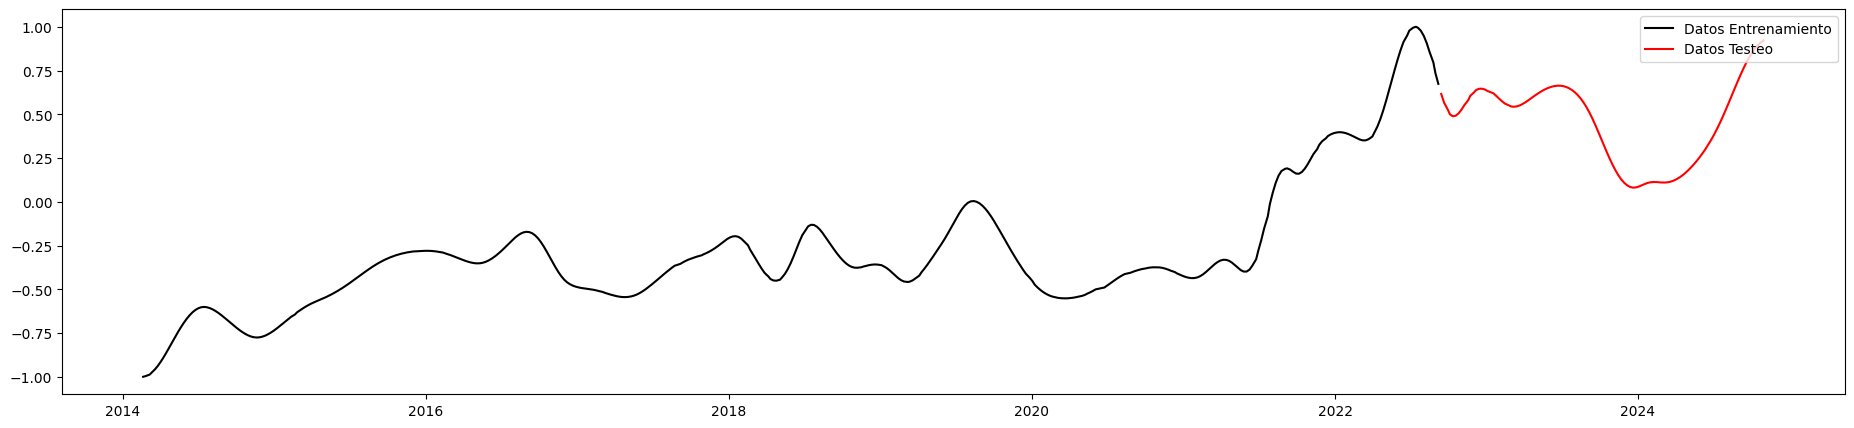

In [27]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [28]:
modelo_residuo = load("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Futuros_maiz/Modelos/LGBM/LGBM_residuo.joblib")

In [29]:
X_train = datos_entrenamiento_residuo[CARACTERISTICAS]
y_train = datos_entrenamiento_residuo["PROMEDIO"]

X_test = datos_testeo_residuo[CARACTERISTICAS]
y_test = datos_testeo_residuo["PROMEDIO"]

modelo_residuo.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)])

prediccion_residuo = modelo_residuo.predict(X_test)
recm = np.sqrt(mean_squared_error(prediccion_residuo,y_test))
ecm = mean_squared_error(prediccion_residuo,y_test)
mae = mean_absolute_error(prediccion_residuo,y_test)
mape = mean_absolute_percentage_error(prediccion_residuo,y_test)

print(f"El error cuadratico medio del modelo es {ecm}")
print(f"La raiz error cuadratico medio del modelo es {recm}")
print(f"El error absoluto medio del modelo es {mae}")
print(f"porcentaje de error absoluto medio del modelo es {mape}")

El error cuadratico medio del modelo es 0.04808630267574456
La raiz error cuadratico medio del modelo es 0.21928589255979183
El error absoluto medio del modelo es 0.18231318680675623
porcentaje de error absoluto medio del modelo es 0.28668838578138184


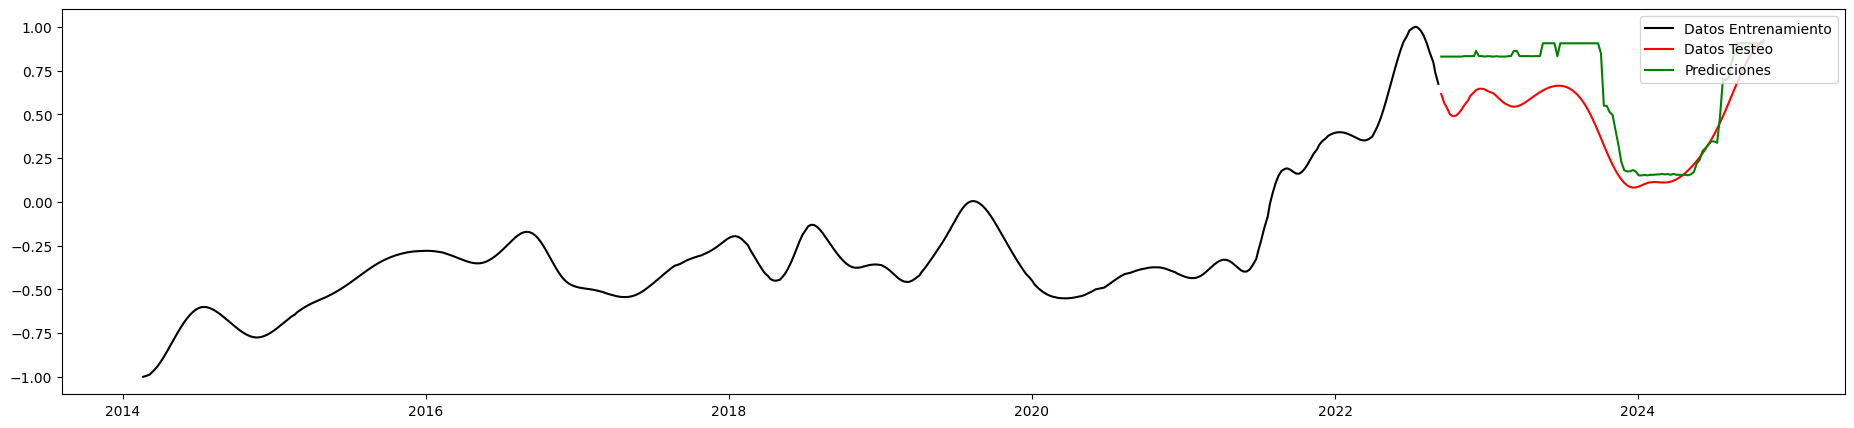

In [30]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_residuo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [31]:
prediccion_residuo = residuo_scaler.inverse_transform(prediccion_residuo.reshape(-1, 1))

# Ensemble

In [32]:
predicciones_emd = prediccion_modo_1 + prediccion_modo_2 + prediccion_residuo

In [33]:
total_datos=len(datos_emd.PROMEDIO)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_testeo = datos_emd[division_entrenamiento:total_datos]


In [34]:
ecm = mean_squared_error( predicciones_emd,datos_testeo.PROMEDIO[:-3])
recm =np.sqrt(mean_squared_error( predicciones_emd,datos_testeo.PROMEDIO[:-3]))
eam = mean_absolute_error( predicciones_emd,datos_testeo.PROMEDIO[:-3])
EPAM = mean_absolute_percentage_error(predicciones_emd,datos_testeo.PROMEDIO[:-3])


#Imprimir las metricas de validacion del modelo
print ( f'El error cuadratico medio del modelo es: {round(ecm,2)} ' )
print ( f'La raiz del error cuadratico medio del modelo es: {round(recm,2)} ' )
print ( f'el error absoluto medio del modelo es: {round(eam,2)} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM} o {round(EPAM * 100 , 2)} %")

El error cuadratico medio del modelo es: 58046.55 
La raiz del error cuadratico medio del modelo es: 240.93 
el error absoluto medio del modelo es: 205.33 
Error porcentual absoluto medio del modelo es: 0.07610876377027516 o 7.61 %


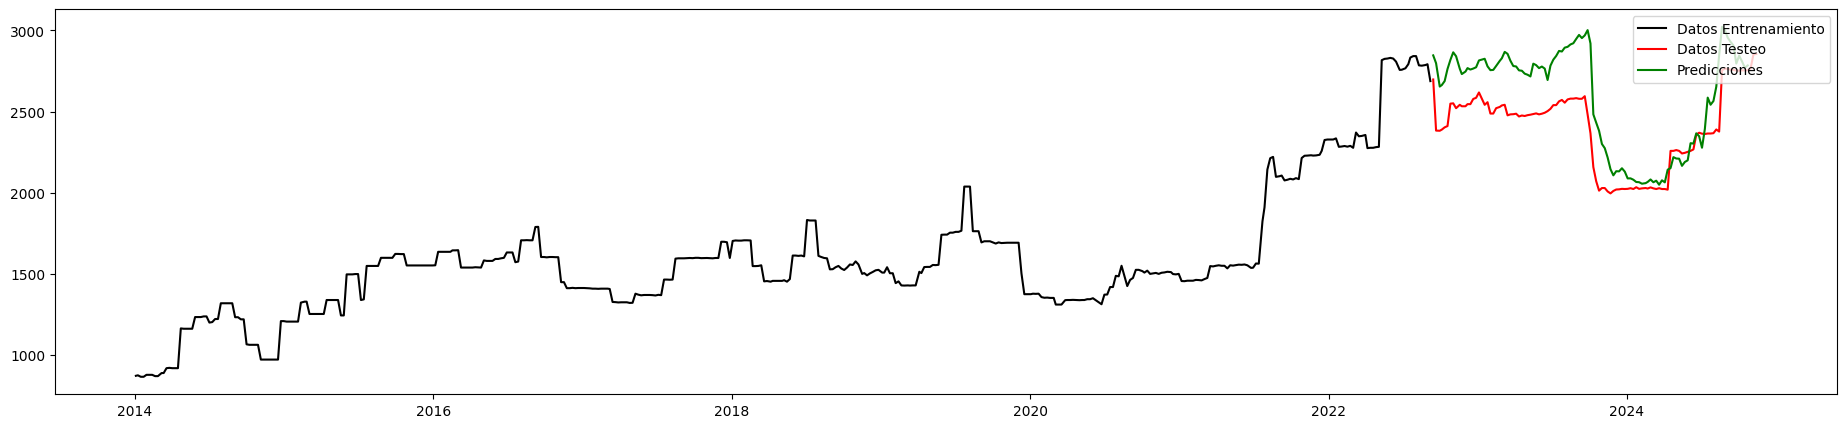

In [35]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index[:-3],predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

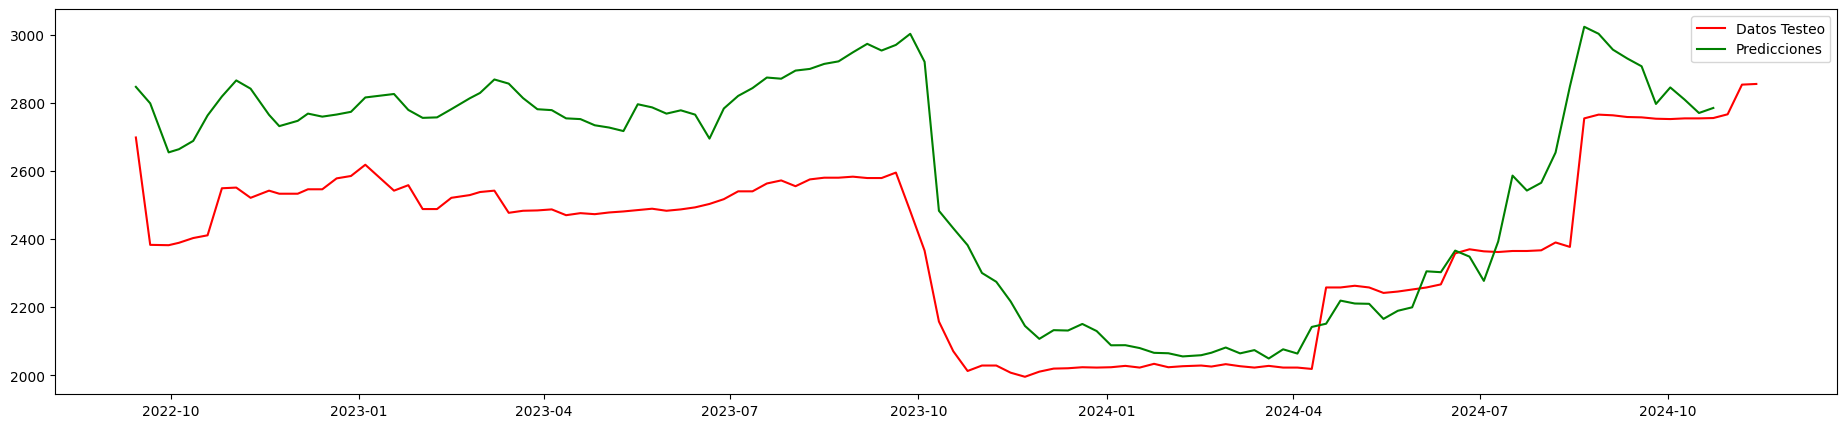

In [36]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index[:-3],predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()


In [37]:
testeo = pd.DataFrame(predicciones_emd,index=datos_testeo.index[:-3],columns=['PROMEDIO'])
testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/otras regiones/Modelado/Barranquillita/Resultados/testeo_LGBM.csv",index=True)